# Model selection with **Arianna** (experimental)

In [1]:
import arianna as arn
import numpy as np 
import matplotlib.pyplot as plt

print('arianna version:', arn.__version__)

arianna version: 0.0.1


In [53]:
# sinusoidal model
def model_A(params, t):
    A, B, P, t0 = params
    return A * np.sin((t / P + t0) * 2 * np.pi) + B

# constant offset model
def model_B(params, t):
    B, = params
    return 0 * t + B

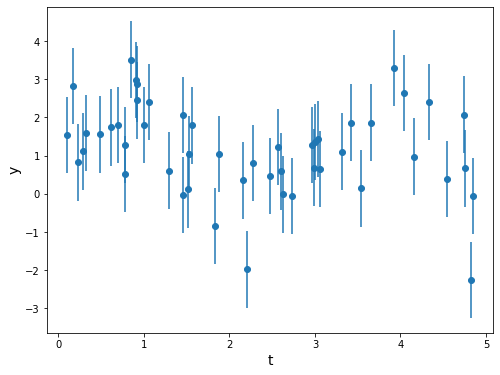

In [54]:
np.random.seed(42)

n_data = 50

# time of observations
t = np.random.uniform(0, 5, size=n_data)

# A=1.0, B=1.0, P=3.0, t=0.0
params_true = [1.0, 1.0, 3.0, 0.0]

# measurement values
yerr = 1.0
y = np.random.normal(model_A(params_true, t), yerr)

plt.figure(figsize=(8,6))
plt.errorbar(x=t, y=y, yerr=yerr, marker='o', ls=' ')
plt.xlabel('t', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.show()

In [55]:
def log_prior_A(params):
    A, B, P, t0 = params

    if np.abs(B)>10.0 or A<0.1 or A>100.0 or P<0.3 or P>10.0 or t0<0.0 or t0>1.0:
        return -np.inf
    return 0.0

def log_prior_B(params):
    B, = params

    if np.abs(B)>10.0:
        return -np.inf
    return 0.0


def log_like_A(params):
    # compute for each x point, where it should lie in y
    y_model = model_A(params, t)
    # compute likelihood
    loglike = -0.5 * (((y_model - y) / yerr)**2).sum()

    return loglike

def log_like_B(params):

    y_model = model_B(params, t)
    # compute likelihood
    loglike = -0.5 * (((y_model - y) / yerr)**2).sum()

    return loglike

In [43]:
ntemps = 40
nwalkers = 4
ndim_A = 4
nsteps = 1000

start_A = 0.5 + 0.001* np.random.randn(ntemps, nwalkers, ndim_A)

sampler_A = arn.ReplicaExchangeSampler(ntemps, nwalkers, ndim_A, log_like_A, log_prior_A)
sampler_A.run_mcmc(start_A, nsteps)

Initialising ensemble of 4 walkers...
Sampling progress: 100%|██████████| 1000/1000 [00:34<00:00, 28.76it/s, nexp=156, ncon=194, accept=0.877]


In [44]:
samples_A = sampler_A.get_chain()
print(samples_A.shape)

(1000, 40, 4, 4)


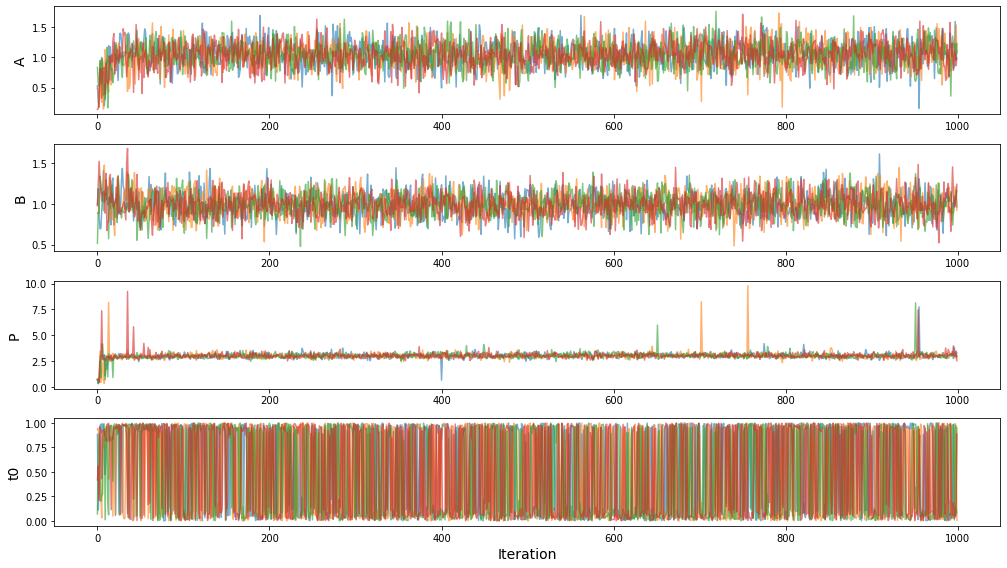

In [45]:
labels = ['A', 'B', 'P', 't0']

plt.figure(figsize=(14,8))
for i in range(ndim_A):
    plt.subplot(ndim_A,1,i+1)
    plt.plot(samples_A[:,0,:,i],alpha=0.6)
    plt.ylabel(labels[i], fontsize=14)
plt.xlabel('Iteration', fontsize=14)
plt.tight_layout()
plt.show()

In [46]:
logz_A = sampler_A.get_logz()
print(logz_A)

-35.73212699705012


In [47]:
ntemps = 40
nwalkers = 4
ndim_B = 1
nsteps = 1000

start_B = 0.5 + 0.001* np.random.randn(ntemps, nwalkers, ndim_B)

sampler_B = arn.ReplicaExchangeSampler(ntemps, nwalkers, ndim_B, log_like_B, log_prior_B)
sampler_B.run_mcmc(start_B, nsteps)

Initialising ensemble of 4 walkers...
Sampling progress: 100%|██████████| 1000/1000 [00:35<00:00, 27.88it/s, nexp=168, ncon=171, accept=0.891]


In [57]:
samples_B = sampler_B.get_chain()
print(samples_B.shape)

(1000, 40, 4, 1)


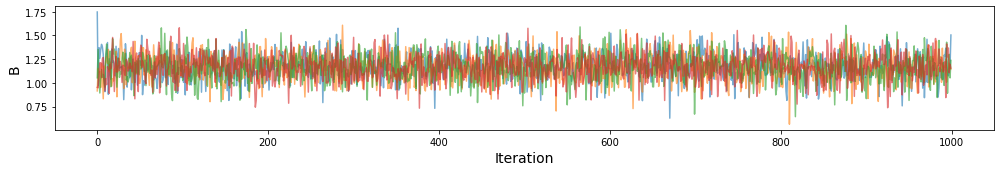

In [58]:
plt.figure(figsize=(14,2.5))
plt.plot(samples_B[:,0,:,0],alpha=0.6)
plt.ylabel('B', fontsize=14)
plt.xlabel('Iteration', fontsize=14)
plt.tight_layout()
plt.show()

In [49]:
logz_B = sampler_B.get_logz()
print(logz_B)

-38.14749485594811


In [50]:
K = np.exp(logz_A-logz_B)

print("The model A is %.2f times more probable than the no-signal model B assuming the models are equally probable a priori." % K)

The model A is 11.19 times more probable than the no-signal model B assuming the models are equally probable a priori.


## Posterior Predictive Checks

In [59]:
t_range = np.linspace(0.0, 5.0, 1000)

obs_A = []
obs_B = []

for s in samples_A[:,0].reshape(-1,ndim_A):
    m = model_A(s, t_range)
    obs_A.append(np.random.normal(m, yerr))

for s in samples_B[:,0].reshape(-1,ndim_B):
    m = model_B(s, t_range)
    obs_B.append(np.random.normal(m, yerr))

obs_A = np.array(obs_A)
obs_B = np.array(obs_B)

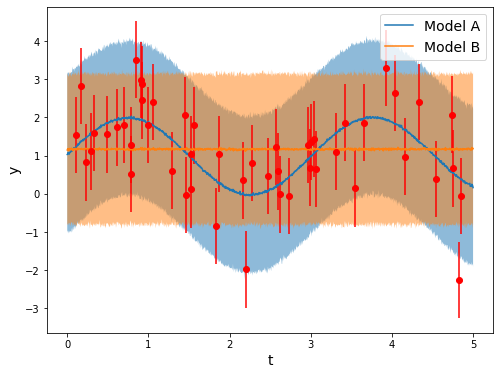

In [68]:
plt.figure(figsize=(8,6))
plt.fill_between(t_range, np.percentile(obs_A,2.5,axis=0),np.percentile(obs_A,97.5,axis=0),alpha=0.5)
plt.plot(t_range, np.mean(obs_A, axis=0), label='Model A')
plt.fill_between(t_range, np.percentile(obs_B,2.5,axis=0),np.percentile(obs_B,97.5,axis=0),alpha=0.5)
plt.plot(t_range, np.mean(obs_B, axis=0), label='Model B')
plt.errorbar(x=t, y=y, yerr=yerr, marker='o', ls=' ', color='red')
plt.xlabel('t', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.legend(fontsize=14)
plt.show()